In [2]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math
from scipy.optimize import curve_fit,least_squares,leastsq
from scipy.interpolate import interp1d
from scipy.optimize import Bounds
from scipy.fft import fft, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal 
from scipy.signal import lombscargle
import operator

In [3]:
plt.style.use('seaborn-whitegrid')

textwidth = 5.9

#Plotting Options
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"

In [5]:
save_path = '/Volumes/KESU/may19/'

#choose filepath to desired data
path = '/Volumes/KESU/may19/Polarized/'

# Import Calibration Data

Import hdf5 data generated from calculate_POL 

In [6]:
with h5py.File(path+ 'poldata.h5', "r") as file:
    waves = file['/waves'][()]
    angles = file['/angles'][()]
    
    R1 = file['/responses1'][()]
    R2 = file['/responses2'][()]

In [7]:
cdse_thickness = 5.01
lambda_min = 7;
lambda_max = 12;
no = pd.read_csv("/Users/kirahart/Dropbox/Dissertation/theory/Lisitsa-o.csv")
ne = pd.read_csv("/Users/kirahart/Dropbox/Dissertation/theory/Lisitsa-e.csv")
delta_n = ne['n']-no['n']

In [8]:
birefringence = interp1d(no['wl'], delta_n, kind='cubic')

In [9]:
def retardance(wavelength):
    d = float(birefringence(wavelength))
    return(cdse_thickness*d*1000)

## Determine Spectral Windows 

$\Delta\lambda$ is the maximum size of the window that can be used to demodulate as a function of center wavelength $\lambda_c$

In [10]:
def delta_lambda(lambda_c):
    delta = retardance(lambda_c)
    return(lambda_c**2/(delta*(1 +(lambda_c**2 / (4*delta**2)))))

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx


Now, determine the spectral windows for demodulaation, returning the wavelength windows and the pixel numbers

In [11]:
lambda_c = []
lambda1  = []
lambda2  = []
pixel_c = []
pixel1  = []
pixel2  = [] 
for l in waves:
    size = delta_lambda(l)
    low  = l-size/2
    high = l+size/2
    if low > lambda_min and high < lambda_max:
        lambda_c.append(l)
        lambda1.append(low)
        lambda2.append(high)
        
        pixel_c.append(find_nearest(waves,l))
        pixel1.append(find_nearest(waves,low))
        pixel2.append(find_nearest(waves,high))

In [12]:
ind = 44
print(lambda_c[ind])
print(lambda1[ind])
print(lambda2[ind])

wavenums = np.divide(1,lambda_c)

11.0
10.321089663831506
11.678910336168494


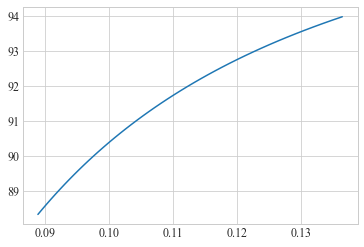

In [13]:
ret = list(map(lambda x: retardance(x), lambda_c))
plt.plot(wavenums,ret)

In [12]:
hf = h5py.File(save_path + 'calibration.h5', 'w')
g = hf.create_group('pixel')
g.create_dataset('wavelength',data= lambda_c)
g.create_dataset('pixel1',data=pixel1)
g.create_dataset('pixel2',data=pixel2)
hf.close()

## Calculate AOLP dependent transmission

This function will correct for differences in transmission over a single period

In [14]:
def transmission_correction(I1,I2,iterations):
    T = 1
    i = 0
    while i < iterations:
        t = np.mean(I1)/np.mean(I2)
        T_update = T*t
        I2_update = t*I2
        I2 = I2_update
        T= T_update
        i = i+1;
    return(T)

In [15]:
t_unpol = np.mean(R1,axis = 0)/np.mean(R2,axis = 0)

transmission_aolp = np.zeros([len(angles),len(pixel_c)])
for a in range(len(angles)):
    I1 = R1[a]
    I2 = R2[a]*t_unpol
    for i in range(len(pixel_c)):
        v = transmission_correction(I1[pixel1[i]:pixel2[i]],I2[pixel1[i]:pixel2[i]],3)
        transmission_aolp[a,i] = v

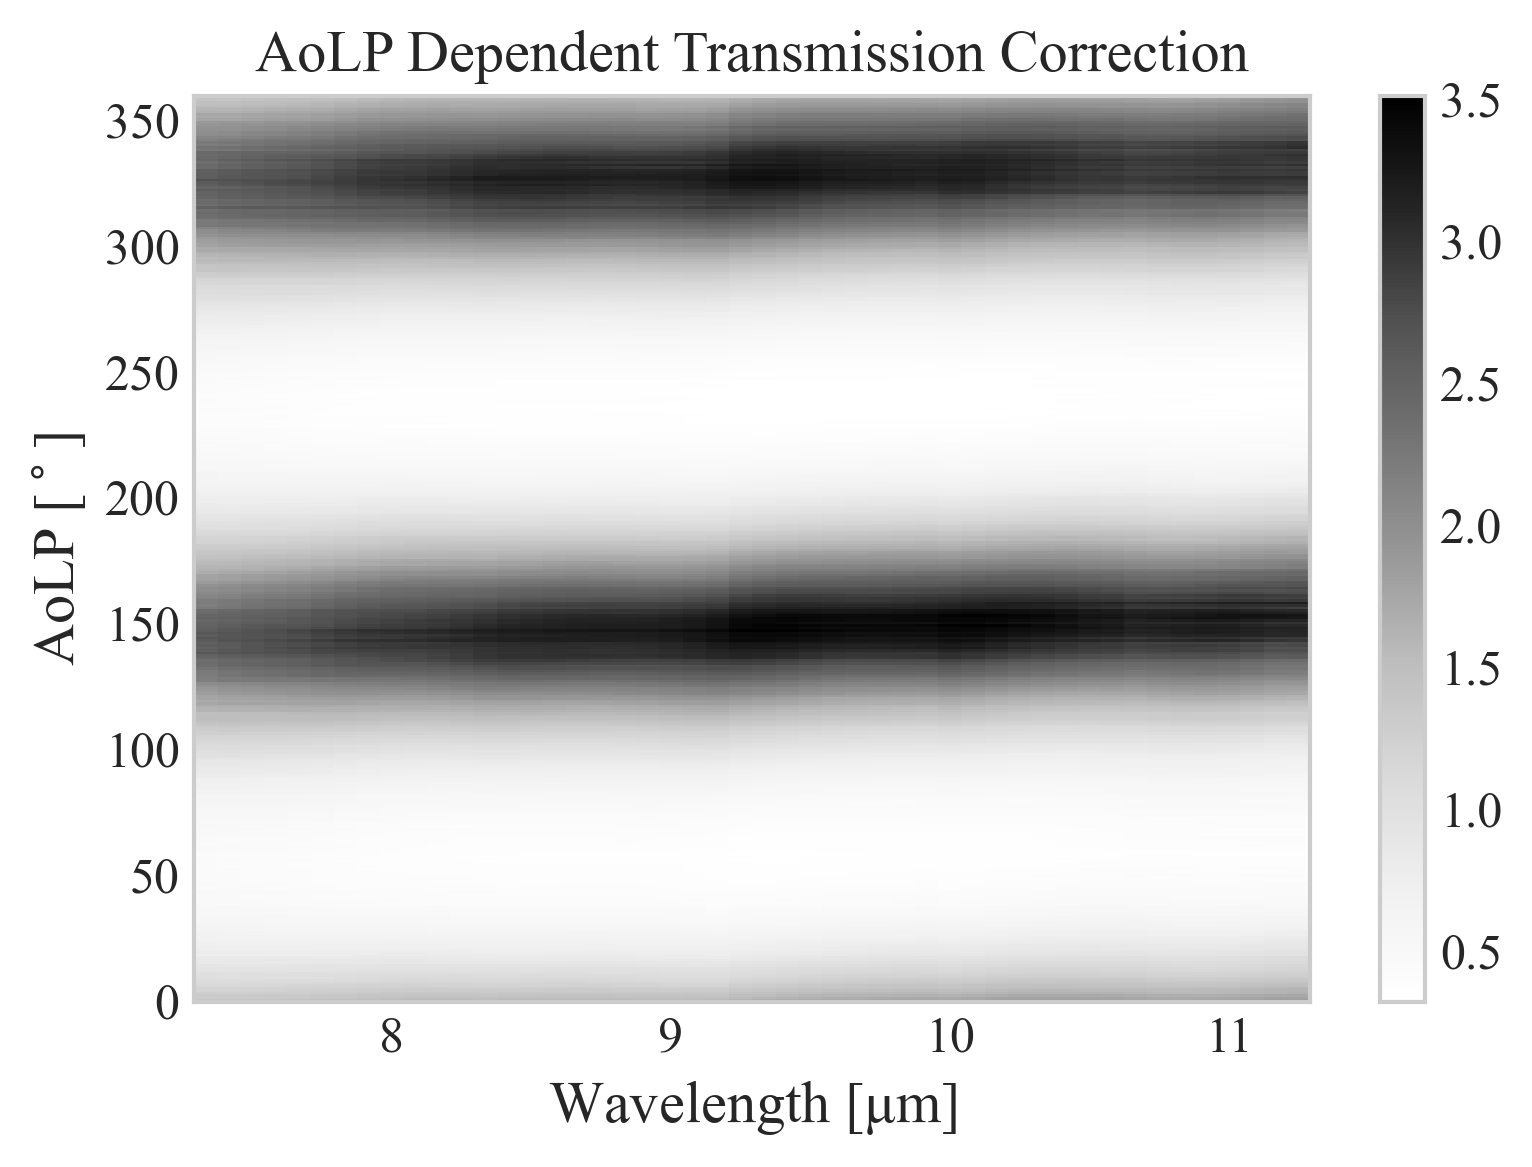

In [16]:
plt.pcolormesh(lambda_c,angles,transmission_aolp,shading='auto')
plt.colorbar()
plt.gcf().set_dpi(300)
plt.title("AoLP Dependent Transmission Correction",fontsize = 14)
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.ylabel('AoLP [$^\circ$]')
plt.show()

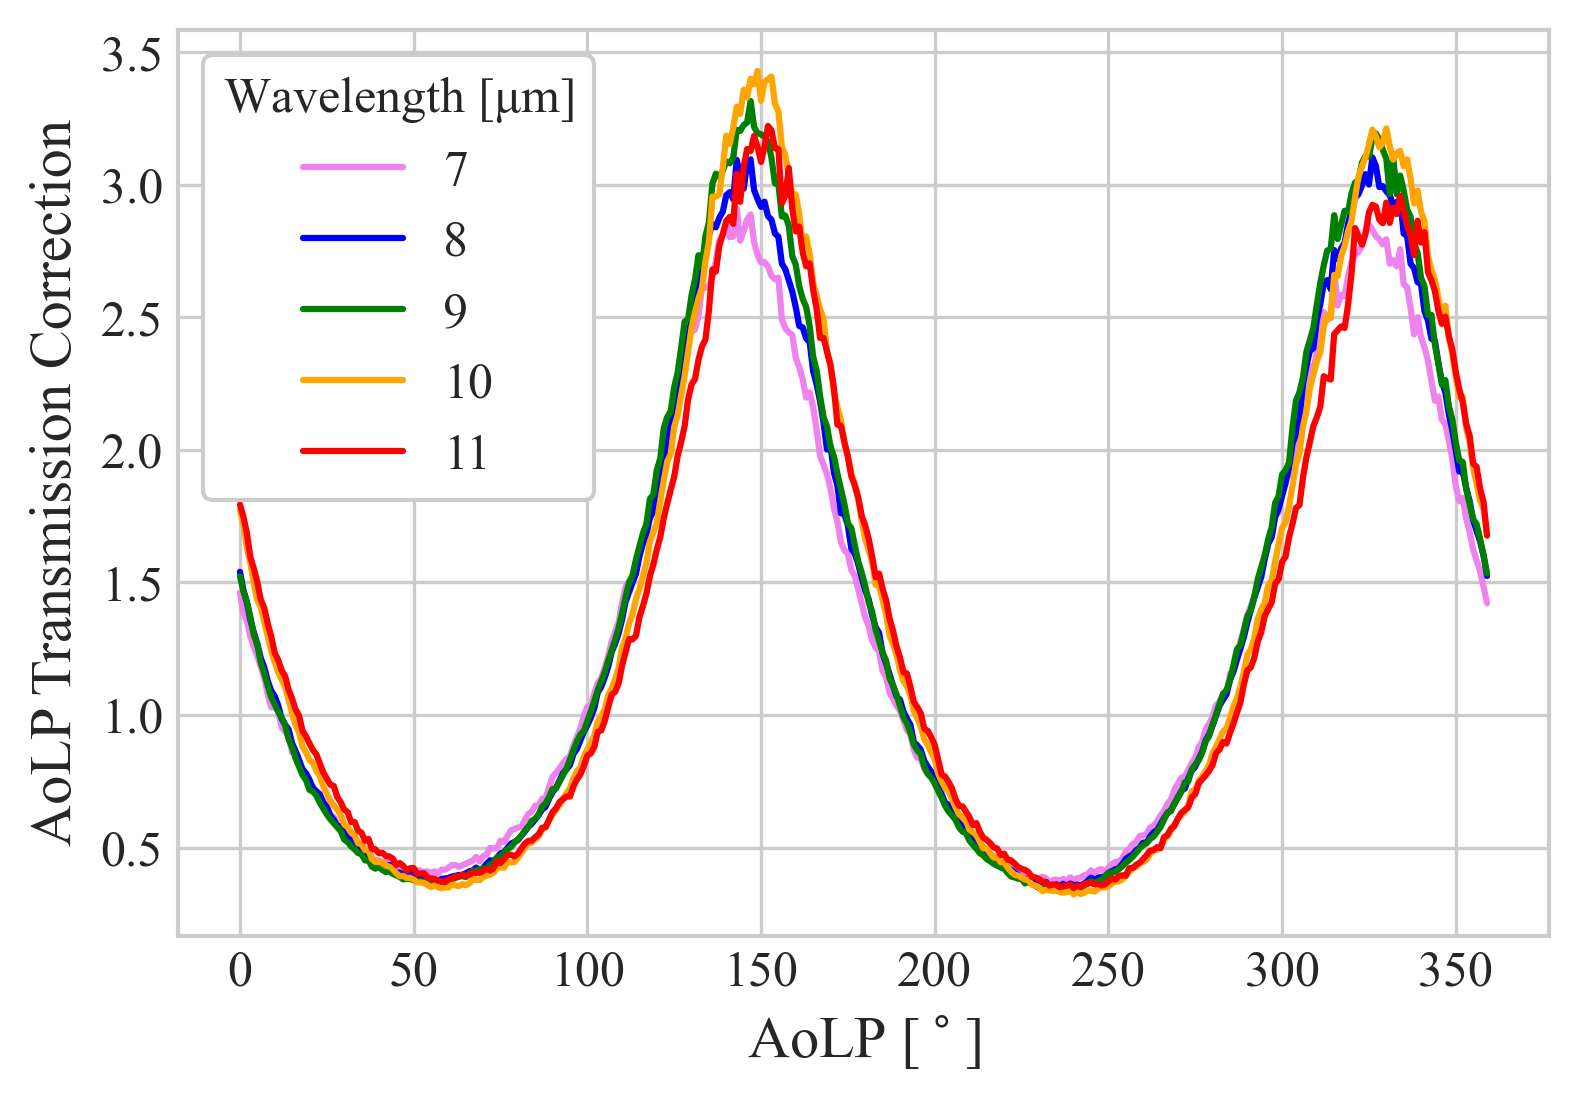

In [56]:
fig = plt.subplots(1,figsize = (textwidth ,4))
plt.plot(angles,transmission_aolp[:,5],'-',color = 'violet',label = str(round(lambda_c[0])),alpha = 1)
plt.plot(angles,transmission_aolp[:,10],'-',color = 'blue',label = str(round(lambda_c[10])),alpha = 1)
plt.plot(angles,transmission_aolp[:,20],'-',color = 'green',label = str(round(lambda_c[20])),alpha = 1)
plt.plot(angles,transmission_aolp[:,30],'-',color = 'orange',label = str(round(lambda_c[30])),alpha = 1)
plt.plot(angles,transmission_aolp[:,40],'-',color = 'red',label = str(round(lambda_c[40])),alpha = 1)

plt.ylabel("AoLP Transmission Correction",fontsize = 14)
plt.xlabel('AoLP [$^\circ$]')
plt.gcf().set_dpi(300)
legend = plt.legend(title = 'Wavelength [$\mathdefault{\mu m}$]',framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

In [57]:
hf = h5py.File(save_path + 'calibration.h5', 'a')
g = hf.create_group('transmission')
g.create_dataset('t_unpol',data= t_unpol)
g.create_dataset('t_pol', data=transmission_aolp)
g.create_dataset('angles',data=angles)
hf.close()

ValueError: Unable to create group (name already exists)

In [58]:
#calculate modulation function for calibration data
calibration_mod = np.zeros([len(angles),len(pixel_c)])
calibration_I1  = np.zeros([len(angles),len(pixel_c)])
calibration_I2  = np.zeros([len(angles),len(pixel_c)])

for a in range(len(angles)):
    I1 = R1[a,pixel_c[0]:pixel_c[-1]+1]/t_unpol[pixel_c[0]:pixel_c[-1]+1]
    I2 = R2[a,pixel_c[0]:pixel_c[-1]+1]*transmission_aolp[a]

    mod_a = (I1-I2)/(I1+I2)
                            
    calibration_I1[a]  = I1
    calibration_I2[a]  = I2
    calibration_mod[a] = mod_a




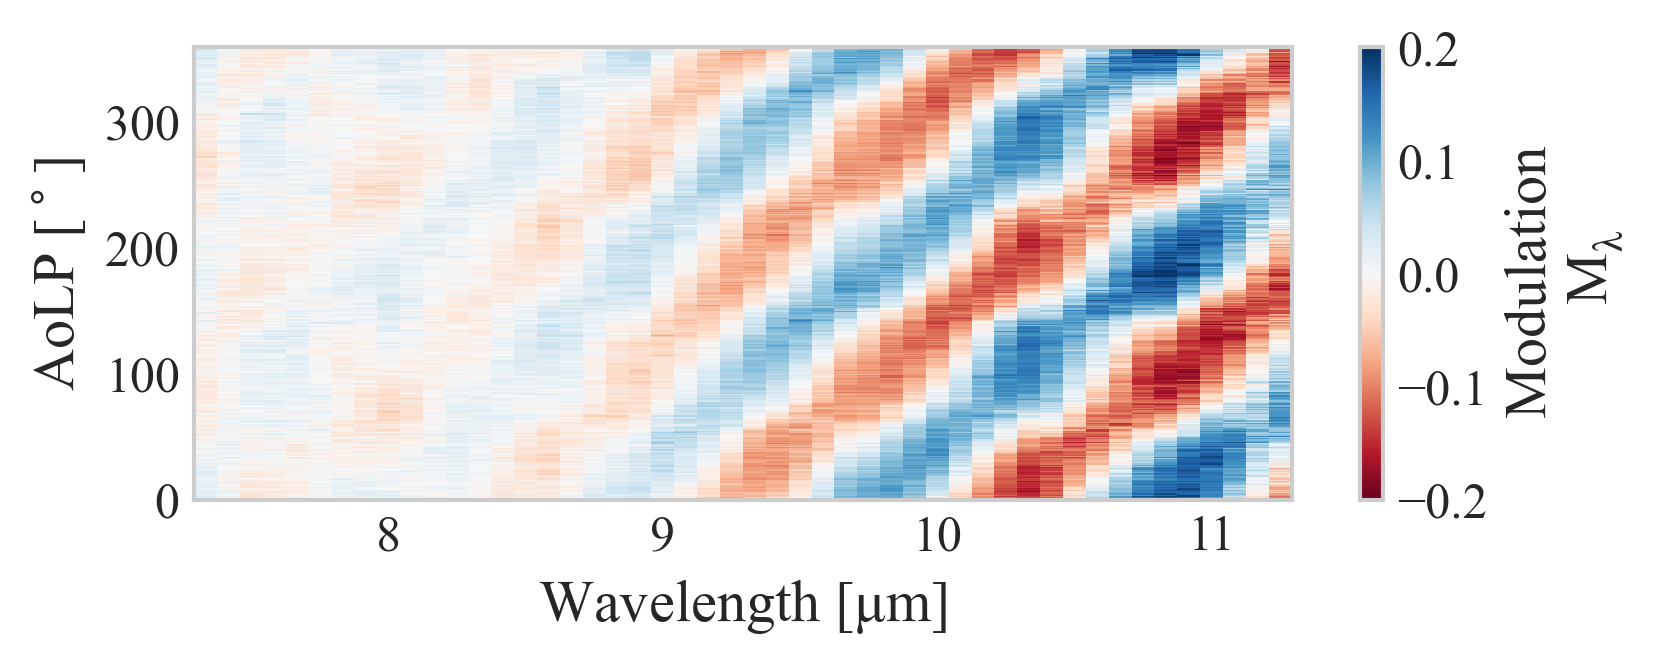

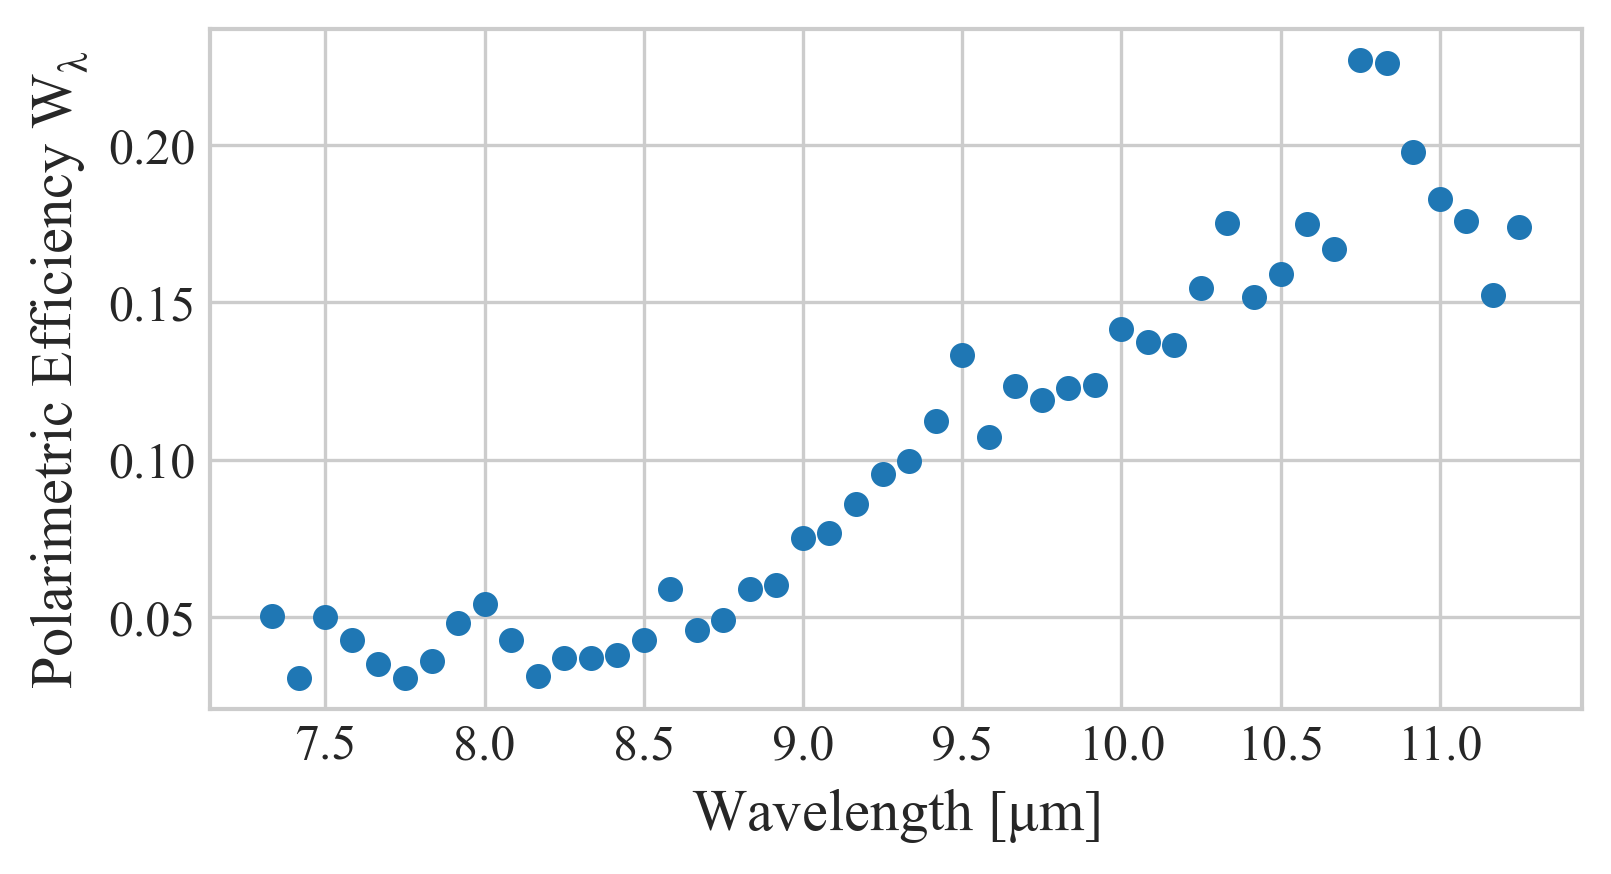

In [60]:
fig = plt.subplots(figsize = [textwidth,2])
plt.pcolormesh(lambda_c,angles,calibration_mod,shading='auto',vmin = -.2,vmax = .2,cmap = 'RdBu')
plt.colorbar(label = "Modulation \n $\mathdefault{M_\lambda}$")
plt.gcf().set_dpi(300)
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.ylabel('AoLP [$^\circ$]')
plt.show()

fig = plt.subplots(figsize = [textwidth,3])
plt.plot(lambda_c,np.max(np.abs(calibration_mod),axis = 0),'.',markersize = 10)
plt.gcf().set_dpi(300)
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.ylabel('Polarimetric Efficiency $\mathdefault{W_\lambda}$')
plt.show()

# Demodulation in Fourier Space

## periodogram

In [61]:
from astropy.timeseries import LombScargle

103.30769230769235


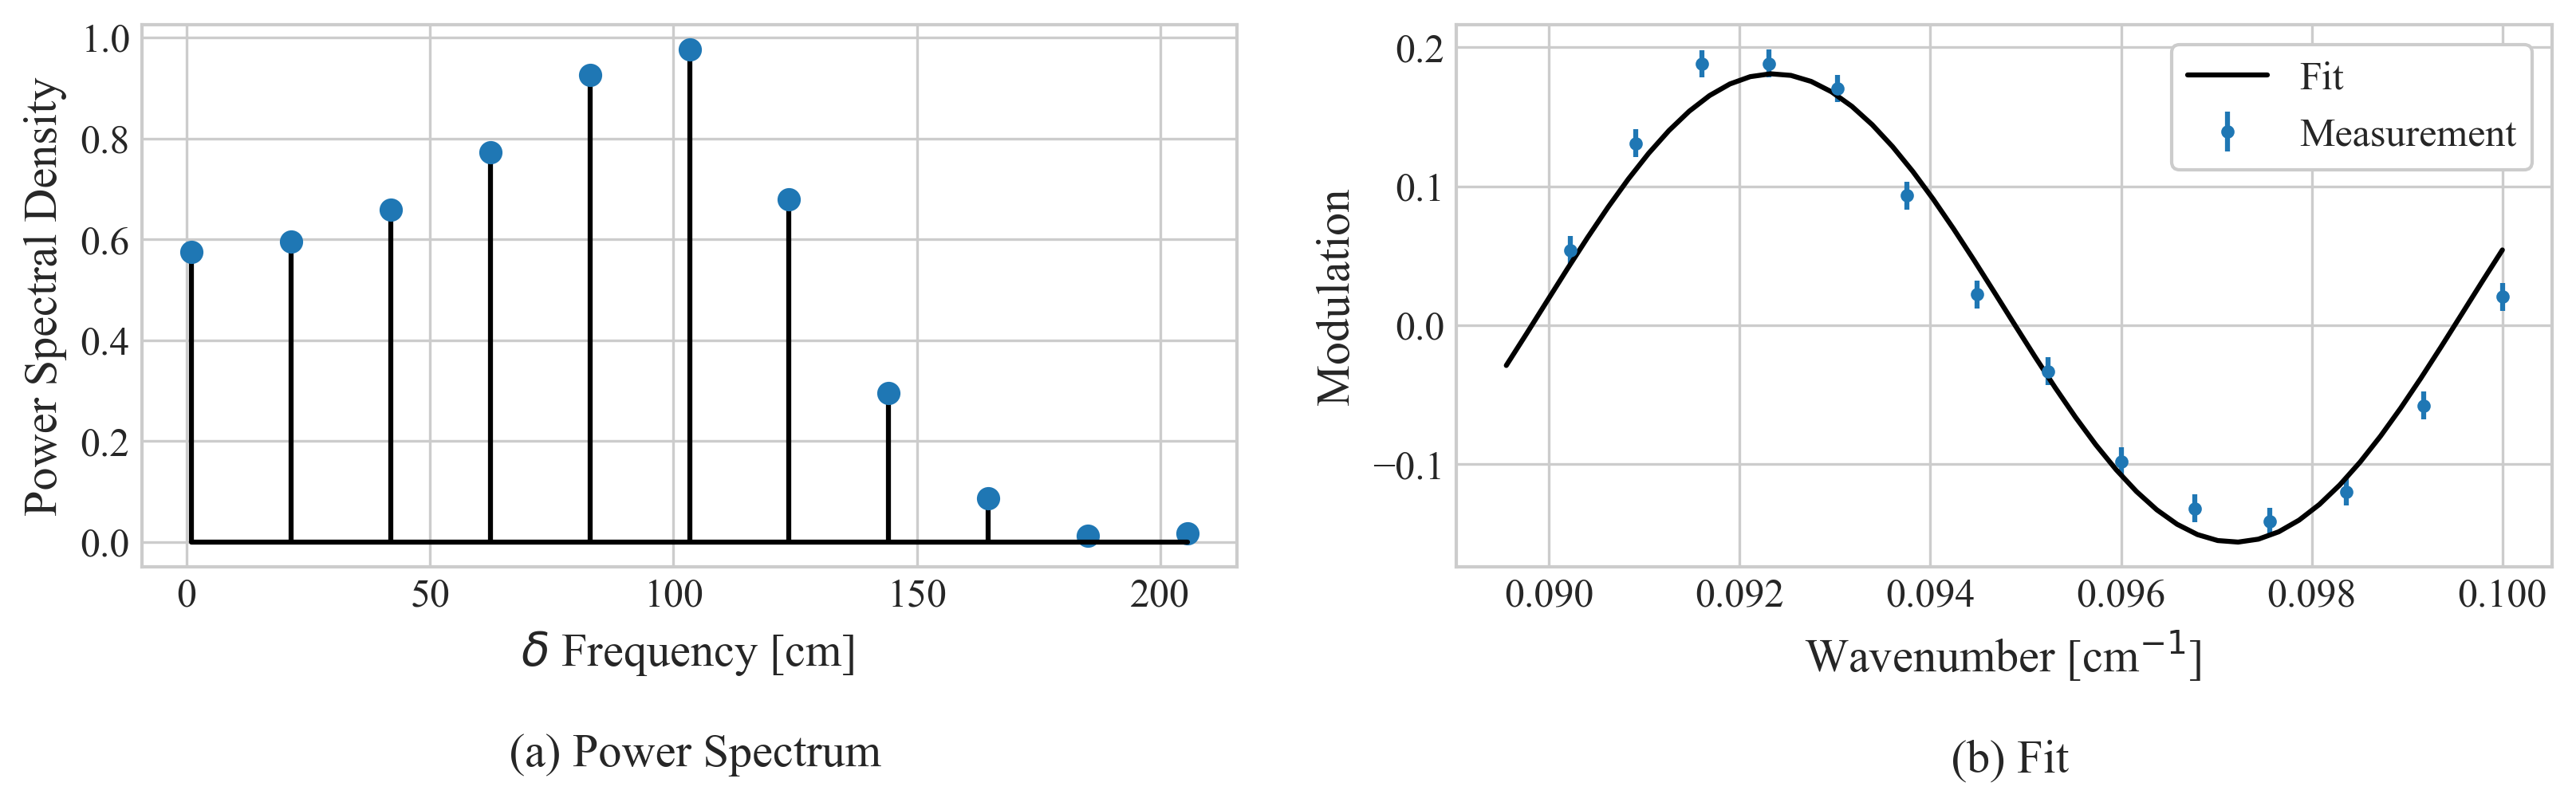

In [182]:
a = 0
j = 35
start = pixel1[j]
stop  = pixel2[j]
n = stop-start;

x = wavenums[start:stop] 
data = calibration_mod[a]
data_err = 0.01
y = data[start:stop]
dy = data_err

ls = LombScargle(x, y,dy)
frequency, power = ls.autopower(minimum_frequency=1,
                                maximum_frequency=200,nyquist_factor= .1) #sampling in 1 period intervalsLombScargle(x, y,dy)

best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(wavenums[stop],wavenums[start])
y_fit = ls.model(t_fit, best_frequency)

[offset,u,q] = ls.model_parameters( best_frequency)
print(best_frequency)

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency, power, 'k',basefmt = 'k')
axes[0].set_xlabel('$\delta$ Frequency [cm] \n \n (a) Power Spectrum')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit,'k', label='Fit')
axes[1].set_xlabel('Wavenumber [cm$^{-1}$] \n \n (b) Fit')
axes[1].set_ylabel('Modulation')
axes[1].errorbar(x,y,yerr = dy,fmt='.', label='Measurement')
legend = plt.legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

In [63]:
def LombFreq(j, data ,data_err):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;

    x = wavenums[start:stop]
    y = data[start:stop]
    dy = data_err[start:stop]

    ls = LombScargle(x, y,dy)
    frequency, power = ls.autopower(minimum_frequency=75,
                                maximum_frequency=185,nyquist_factor= 1000) #sampling in 1 period intervalsLombScargle(x, y,dy)

    best_frequency = frequency[np.argmax(power)]
    
    return(best_frequency)


Fit apply over all AoLP to determine carrier freq

In [64]:
carrier = np.zeros([36])
for j in range(36):
    freqs = np.zeros(360)
    for a in range(360):
        data = calibration_mod[a]
        data_err = calibration_mod[a]
        freqs[a] = LombFreq(j, data ,data_err)
    carrier[j] = np.median(freqs)

Text(0.5, 0, 'Center Wavelength [$\\mathdefault{\\mu}$m]')

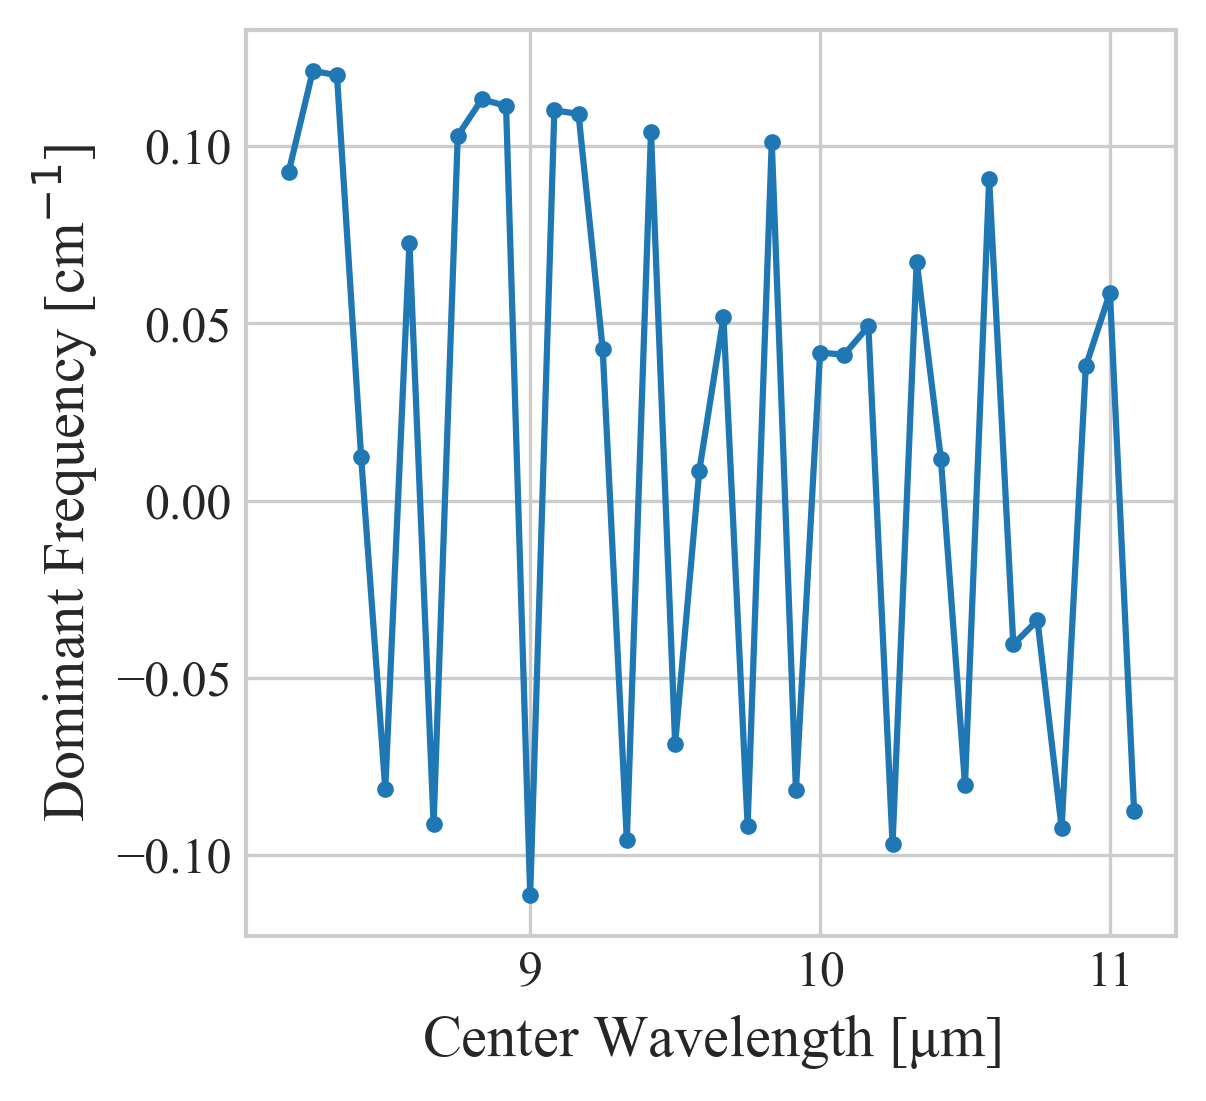

In [89]:
fig = plt.subplots(figsize = [4,4])
plt.plot(lambda_c[10:46],np.cos(2*np.pi*carrier)/lambda_c[10:46],'.-')
#plt.ylim([94,100])
plt.gcf().set_dpi(300)
plt.ylabel("Dominant Frequency [cm$^{-1}$]")
plt.xlabel('Center Wavelength [$\mathdefault{\mu}$m]')

In [199]:
def LombModel(j, data ,data_err,freq):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;

    x = wavenums[start:stop]
    y = data[start:stop]
    dy = data_err[start:stop]

    ls = LombScargle(x, y,dy)
    frequency, power = ls.autopower(minimum_frequency=75,
                                maximum_frequency=175,nyquist_factor= 1000) #sampling in 1 period intervalsLombScargle(x, y,dy)
    
    idx = find_nearest(frequency, freq)
    probability = [0.1, 0.05, 0.01]
    prob = ls.false_alarm_probability(power[idx])  
    
   
    y_fit = ls.model(x, freq)
    error = np.mean(y-y_fit)**2/np.mean(y)**2

    [offset,u,q] = ls.model_parameters(freq)
    
    return([u,q,0.5*np.arctan2(u,q)])

In [200]:
j = 19
results = np.zeros([360,4])
for a in range(360):
    data = calibration_mod[a]
    data_err = calibration_mod[a]/100
    freq = carrier[j]
    results[a] = LombModel(j, data ,data_err,freq)  

In [201]:
offset = []
angles = np.concatenate([np.linspace(0,180,180),np.linspace(0,180,180)]);
results = np.zeros([36,360,4])
for j in range(0,36):
    
    for a in range(0,360):
        data = calibration_mod[a]
        data_err = calibration_mod[a]/100
        freq = carrier[j]
        results[j,a] = LombModel(j, data ,data_err,freq)  
    delta = angles-180*results[j,:,3]/np.pi
    offset.append(delta)

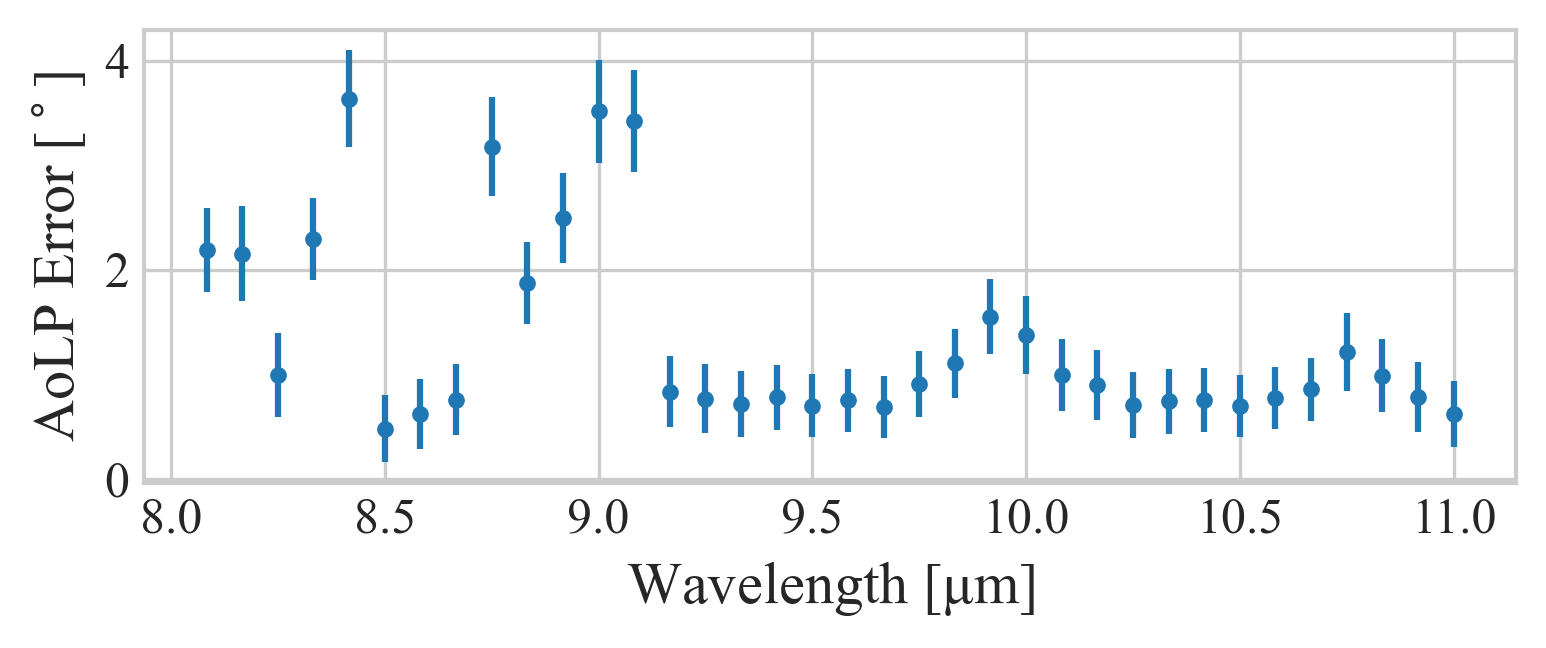

In [273]:
aolps = []
for i in range(36):
    aolps.append(np.linspace(-np.pi/2,np.pi/2,180))

fig, axes = plt.subplots(1,figsize=(5.9,2)); 
plt.errorbar(lambda_c[9:45],np.mean(np.abs(results[:,0:180,3] - aolps)-0.7,axis =1)*18/np.pi,yerr =np.std(results[:,0:180,3]-aolps,axis =1)/np.pi,fmt = '.')
plt.gcf().set_dpi(300)
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.ylabel('AoLP Error [$^\circ$]')
plt.show()


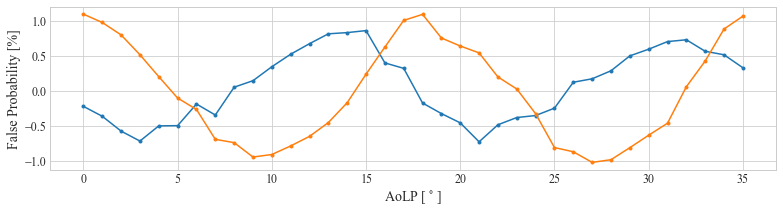

In [173]:
i =30
fig, axes = plt.subplots(1,figsize=(13, 3)); 
plt.plot(results[i,0:359:10,0]/(WQ[i]),'.-')
plt.plot(results[i,0:359:10,1]/(WU[i]),'.-')
plt.ylabel('False Probability [%]')   
plt.xlabel('AoLP [$^\circ$]')
#axes[0].set_ylim([0,1])

'''axes[1].plot(results[i,:,0],'.', label = 'q')
axes[1].plot(results[i,:,1],'.', label = 'u')
axes[1].legend()
plt.gcf().set_dpi(300)
axes[1].set_xlabel('AoLP [$^\circ$]')'''

plt.show()

determine efficiency, offset

In [174]:
def solve_amp(data,angles):
    np_fft = np.fft.fft(data)
    amplitudes = 2 / len(angles) * np.abs(np_fft)
    return(amplitudes.max())

In [175]:
WQ = np.zeros(35)
WU = np.zeros(35)
for j in range(34):
    results = np.zeros([len(angles),4])
    for a in range(len(angles)):
        data = calibration_mod[a]
        data_err = calibration_mod[a]/100
        freq = carrier[j]
        results[a] = LombModel(j, data ,data_err,freq)  
    WQ[j] = solve_amp(results[:,0],angles)
    WU[j] = solve_amp(results[:,1],angles)

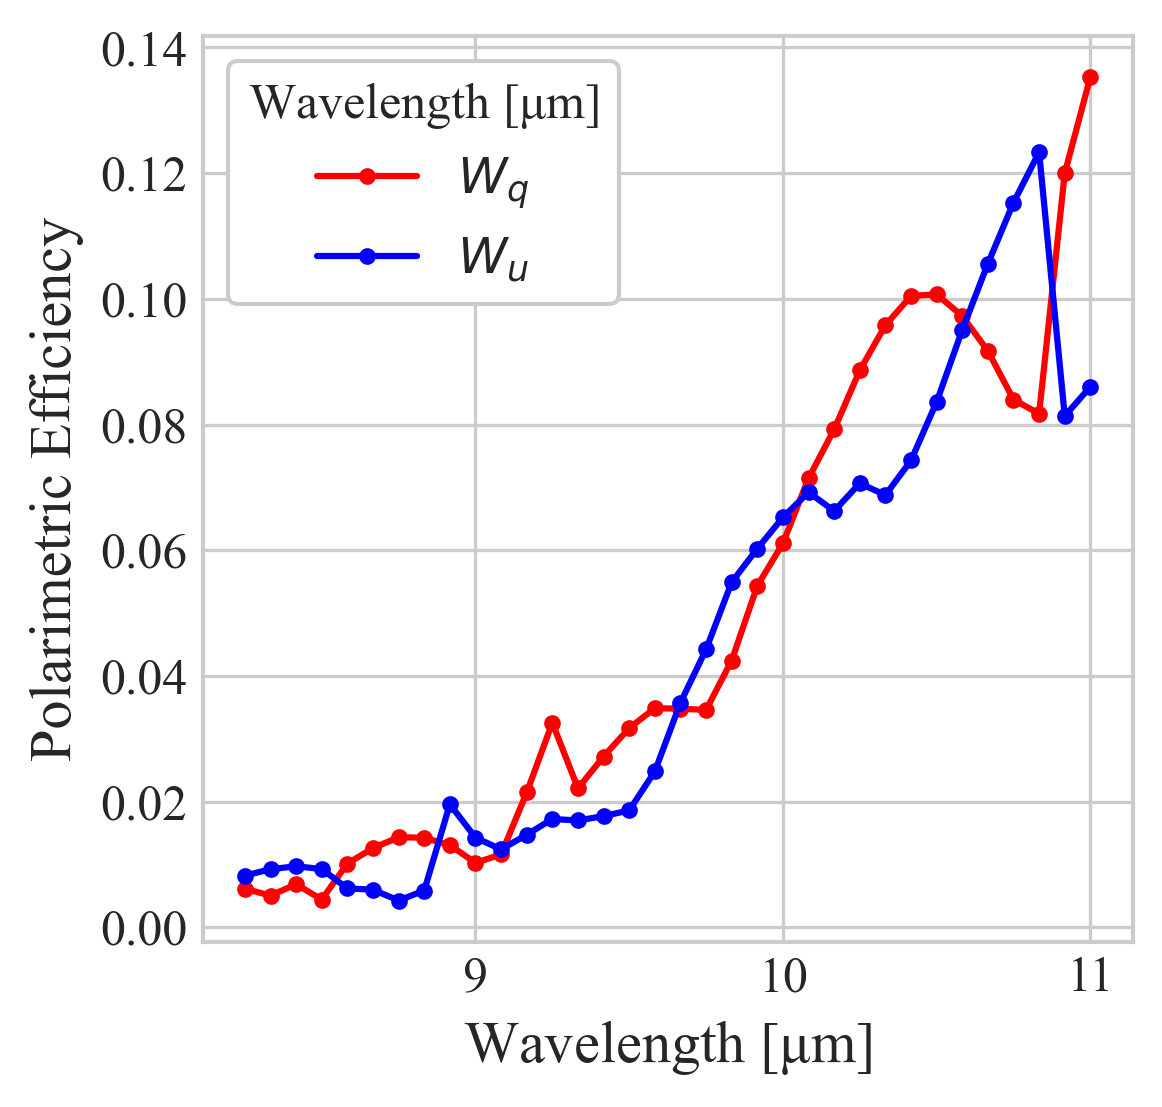

In [176]:
fig = plt.subplots(figsize = [4,4])
plt.plot(lambda_c[11:45],WQ[:34],'r.-',label = '$W_q$')
plt.plot(lambda_c[11:45],WU[:34],'b.-',label = '$W_u$')
plt.gcf().set_dpi(300)
plt.ylabel("Polarimetric Efficiency")
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
legend = plt.legend(title = 'Wavelength [$\mathdefault{\mu m}$]',framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()
plt.show()

In [256]:
hf = h5py.File(save_path + 'calibration.h5', 'a')
g = hf.create_group('polarization')
g.create_dataset('carrier',data= carrier)
g.create_dataset('WQ', data=WQ)
g.create_dataset('WU',data=WU)
hf.close()

# Radiometric Calibration

In [90]:
from radiometric.LUT import create_LUT_df, determine_reference, applyNUC_to_LUT

from NUC.NUC_functions import import_NUC, apply_NUC, get_slice, determine_slope
from NUC.NUC_functions import determine_dark, apply_DFC_to_df
from NUC.NUC_functions import pixel_registration

from matplotlib import cm
from scipy.optimize import curve_fit
import matplotlib.colors as colors


In [91]:
#choose filepath to desired data
path = '/Volumes/KESU/may19/LUTS/'
#note cam definitions are flipped as of FLIRPY ffc fix 
cal_file2 =  '/Volumes/KESU/calibration_files/cam1pixel.h5'
cal_file1 =  '/Volumes/KESU/calibration_files/cam2pixel.h5'

waves= np.linspace(7,12,61)
temps = np.linspace(25,80,12)

#select ROI
ymin2 = 90; ymax2 = 150;
ymin1 = 120; ymax1 = 180;

FOV = 5.33 ;
HFOV = FOV/4;
angles = np.round(np.linspace(-HFOV,HFOV,ymax2-ymin2))

temps

array([25., 30., 35., 40., 45., 50., 55., 60., 65., 70., 75., 80.])

In [92]:
im1 = []
im2 = []
std1 = []
std2 = []
for t in temps:
    filename = path +str(round(t))+'C.h5'

    with h5py.File(filename, "r") as file:
        image1 = np.mean(file['imgs1'][()],axis = 0)
        image2 = np.mean(file['imgs2'][()],axis = 0)
        s1 = np.std(file['imgs1'][()],axis = 0)
        s2 = np.std(file['imgs2'][()],axis = 0)


    c1 = (image1-np.mean(image1[125:175,25:75]))
    c2 = (image2-np.mean(image2[100:150,25:75]))
    
    im1.append(c1)
    im2.append(c2)
    std1.append(s1)
    std2.append(s2)

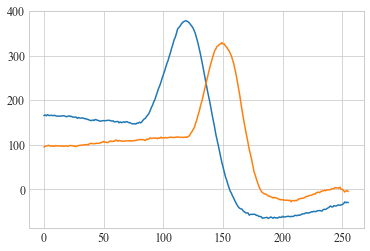

In [93]:
#Find location of 0 degree point
p2 = pixel_registration(im2[10],cal_file2,waves,0,256)
p1 = pixel_registration(im1[10],cal_file1,waves,0,256)
plt.plot(np.mean(p2,axis = 1))
plt.plot(np.mean(p1,axis = 1))
plt.show()

y1 = np.argmax(np.mean(p1,axis = 1))
y2 = np.argmax(np.mean(p2,axis = 1))

In [94]:
responses = np.zeros([len(temps),len(waves)])
responses1 = np.zeros([len(temps),len(waves)])
responses2 = np.zeros([len(temps),len(waves)])
responses_err = np.zeros([len(temps),len(waves)])
responses_err1 = np.zeros([len(temps),len(waves)])
responses_err2 = np.zeros([len(temps),len(waves)])

for t in range(len(temps)):
    p2 = pixel_registration(im2[t],cal_file2,waves,0,256)
    p1 = pixel_registration(im1[t],cal_file1,waves,0,256)
    s2 = pixel_registration(std2[t],cal_file2,waves,0,256)
    s1 = pixel_registration(std1[t],cal_file1,waves,0,256)

    responses1[t]= p1[y1]
    responses_err1[t]= s1[y1]
    responses2[t]= p2[y2]
    responses_err2[t]= s2[y2]
    
    err = np.sqrt((s2[y2]/p2[y2])**2+(s1[y2]/p1[y2])**2)
    responses[t]= p2[y2]+p1[y1]
    responses_err[t]= err*responses[t]

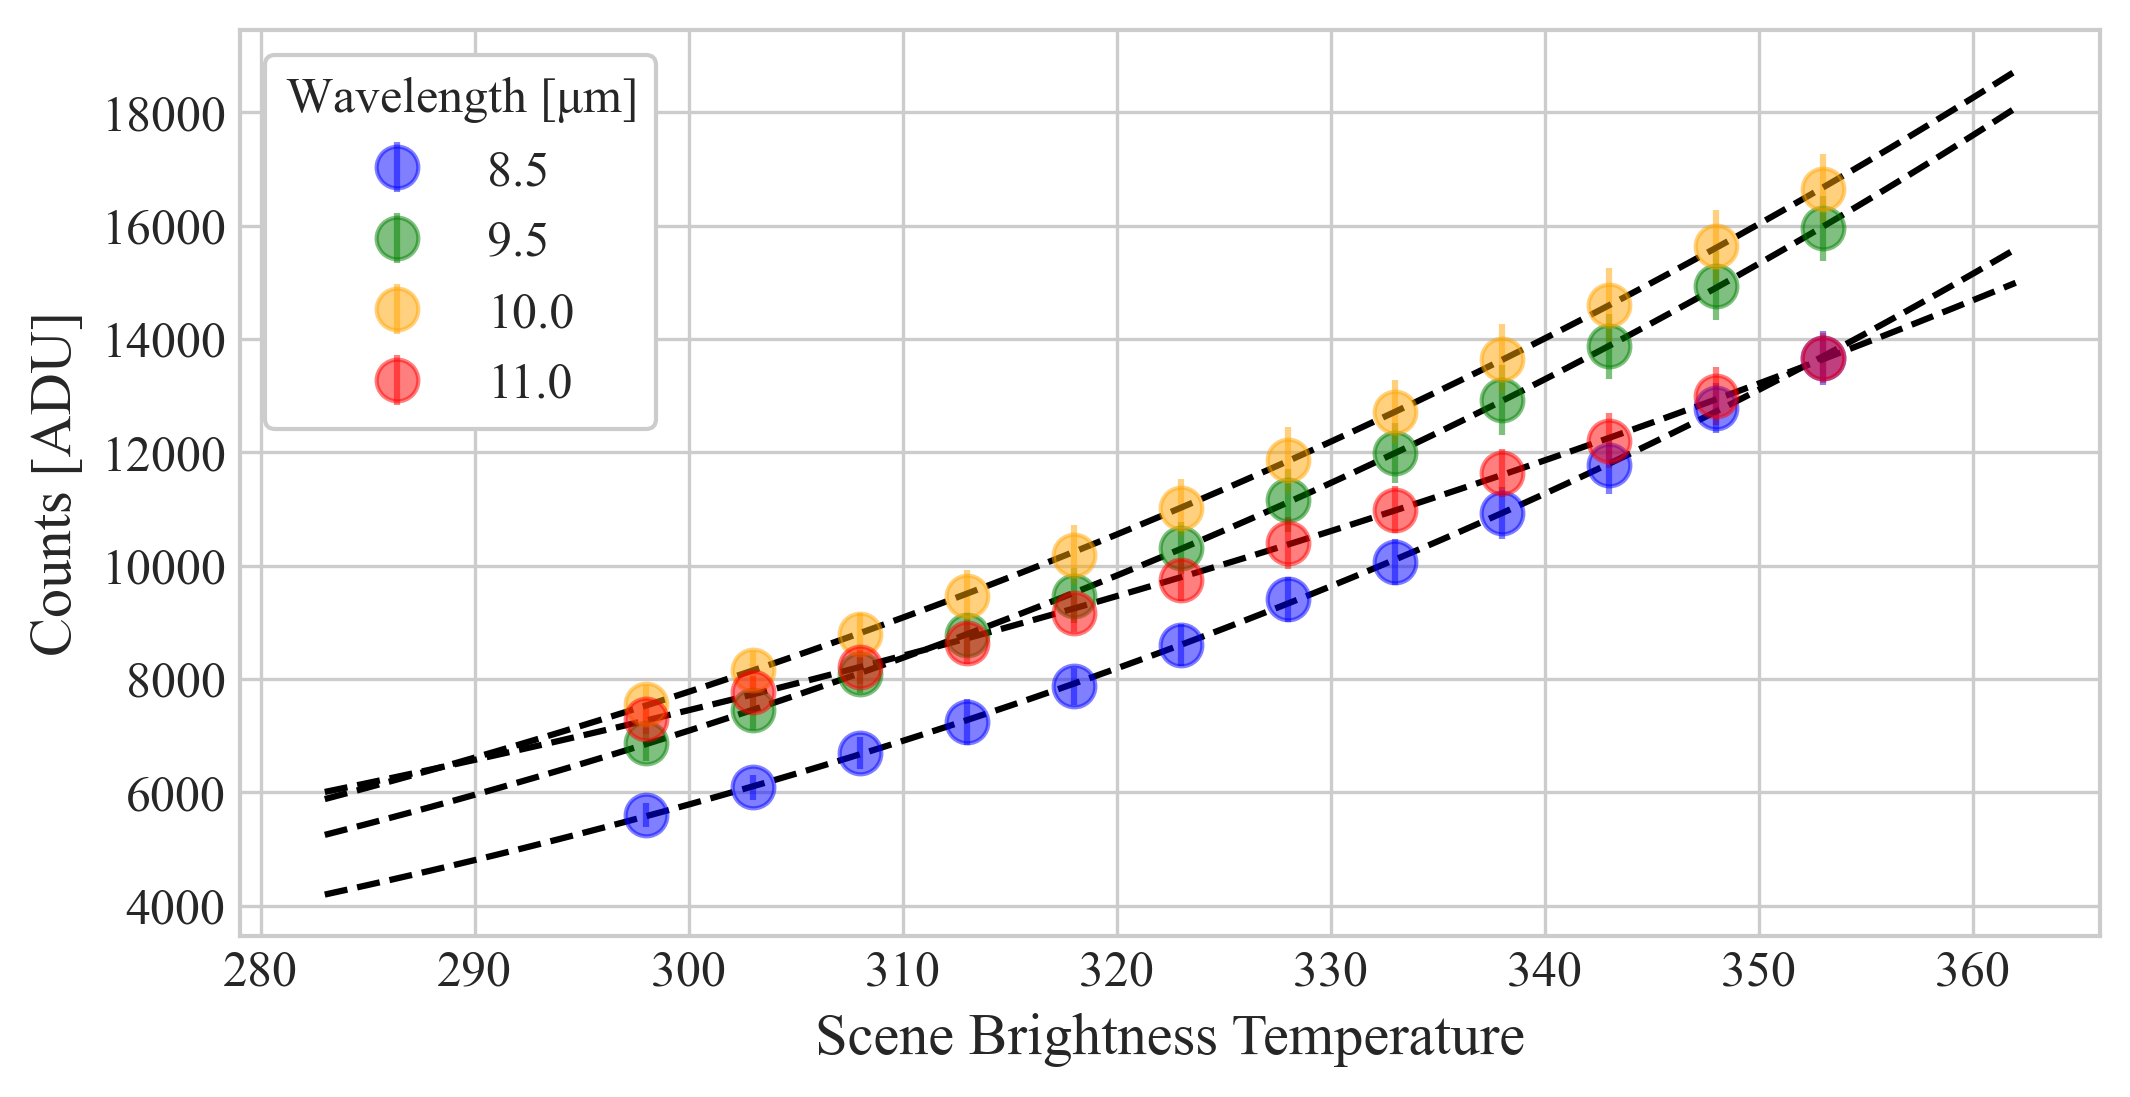

array([ 6.71336013e-07, -2.45864692e+01])

In [275]:
""" Fitting Function"""
def func(x, a, b):
    y = a*(x-b)**4 
    return y

colors = ['blue','green','orange','red']
fig = plt.subplots(figsize = [8,4])
plt.gcf().set_dpi(300)
nu =[14,26,32,44]
for i in range(4):
    ind = nu[i]
    start = pixel1[ind]
    stop  = pixel2[ind]

    x = temps + 273
    y = np.sum(responses[:,start:stop]+300,axis = 1)
    y_err = np.sum(responses_err[:,start:stop],axis = 1)
    x2 = np.arange(10,90) +273

    popt, pcov = curve_fit(func, x, y, sigma = y_err)

    plt.plot(x2, func(x2, *popt), 'k--')
    plt.errorbar(x,y,yerr = y_err,fmt='.',color = colors[i],alpha=0.5,markersize = 20,label = str(np.round(lambda_c[ind],1)))

plt.xlabel("Scene Brightness Temperature")
plt.ylabel("Counts [ADU]")
legend = plt.legend(title = 'Wavelength [$\mathdefault{\mu m}$]',framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

popt

In [119]:
var = np.zeros([36,2])
covar = np.zeros([36,2])

for ind in range(36):
    start = pixel1[ind]
    stop  = pixel2[ind]
    
    x = temps + 273
    y = np.sum(responses[:,start:stop]+100,axis = 1)
    y_err = np.sum(responses_err[:,start:stop],axis = 1)

    popt, pcov = curve_fit(func, x, y, sigma = y_err)

    var[ind] = popt
    covar[ind] = np.sqrt(np.diag(pcov))

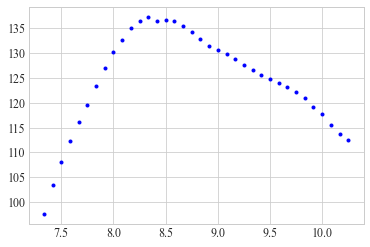

In [120]:
plt.errorbar(lambda_c[:36],var[:,1],yerr=covar[:,0],fmt = 'b.')
plt.show()

In [130]:
temp = np.linspace(-20,50,40) + 273
nedts = np.zeros([len(waves),len(temp)])
for i in range(36):
    for t in range(len(temp)):
        tem = temp[t]
        snr =  0
        delta = 0
        start = pixel1[i]
        stop  = pixel2[i]

        e = np.sum(responses_err[:,start:stop]/responses[:,start:stop])
        
        while snr < e:
            snr = np.abs(func(tem+delta/2,var[i,0],var[i,1])-func(tem-delta/2,var[i,0],var[i,1]))
            delta = delta +.001 

        nedts[i,t] = delta


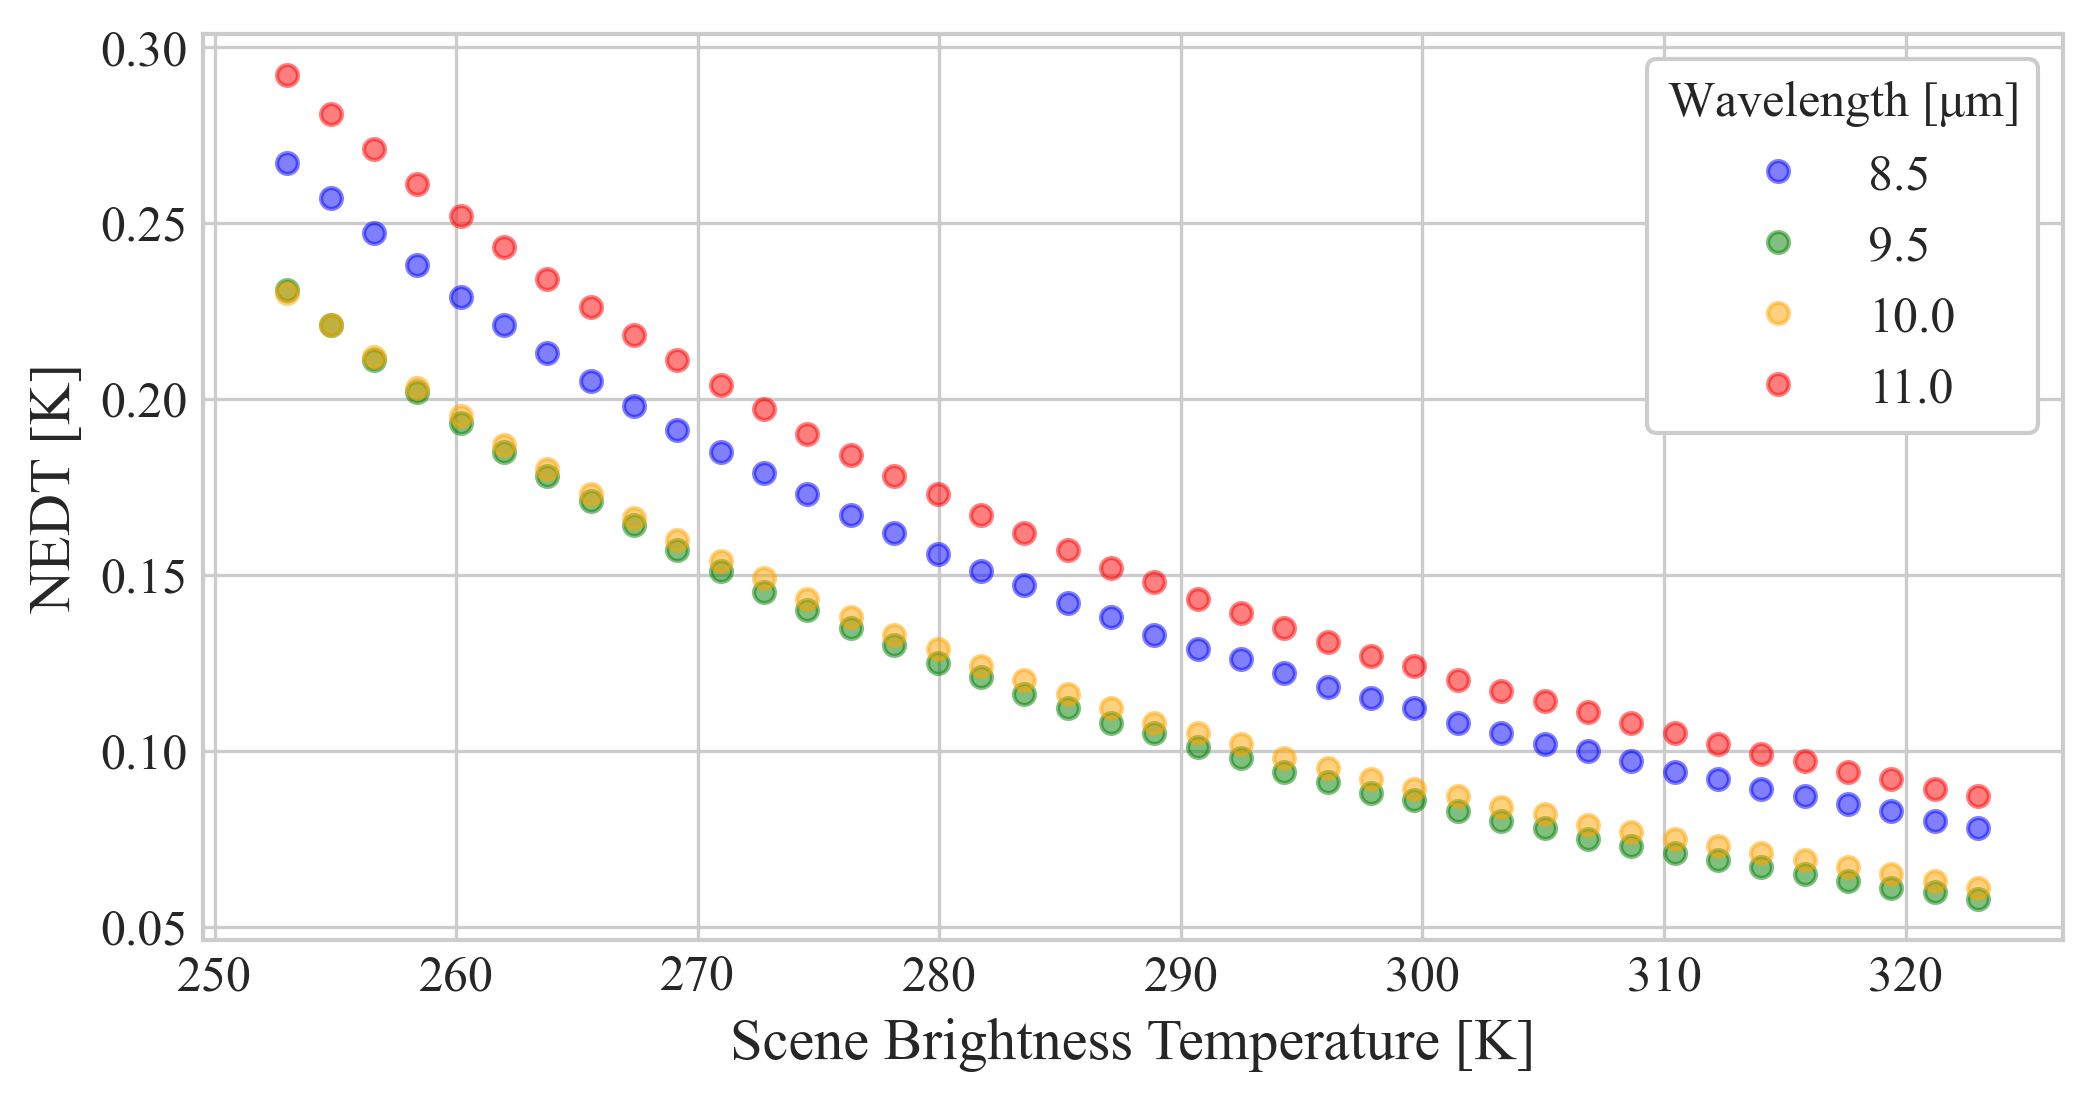

In [279]:
fig = plt.subplots(figsize = [8,4])
plt.gcf().set_dpi(300)
for i in range(4):
    ind = nu[i]
    plt.plot(temp,nedts[ind-10],'.',label = str(np.round(lambda_c[ind],1)), markersize = 10,color = colors[i],alpha = 0.5)
plt.legend( title='Wavelength [$\mathdefault{\mu}$m]')
plt.gcf().set_dpi(300)
plt.ylabel("NEDT [K]")
plt.xlabel("Scene Brightness Temperature [K]")

legend = plt.legend(title = 'Wavelength [$\mathdefault{\mu m}$]',framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

In [275]:
hf = h5py.File(save_path + 'calibration.h5', 'a')
g = hf.create_group('radiometric')
g.create_dataset('nedt',data= nedts)
g.create_dataset('var',data=var)
g.create_dataset('covar',data=covar)
hf.close()

In [88]:
hf.close()

In [301]:
nedts[14]

array([0.404, 0.394, 0.385, 0.375, 0.367, 0.358, 0.35 , 0.342, 0.334,
       0.327, 0.319, 0.312, 0.306, 0.299, 0.292, 0.286, 0.28 , 0.274,
       0.268, 0.263, 0.257, 0.252, 0.247, 0.242, 0.237, 0.232, 0.228,
       0.223, 0.219, 0.214, 0.21 , 0.206, 0.202, 0.198, 0.195, 0.191,
       0.187, 0.184, 0.181, 0.177])

In [294]:
aolps = []
efff = []
for i in range(36):
    aolps.append(np.linspace(-np.pi/2,np.pi/2,180))

for i in range(40):
    efff.append(WQ+WU)

/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


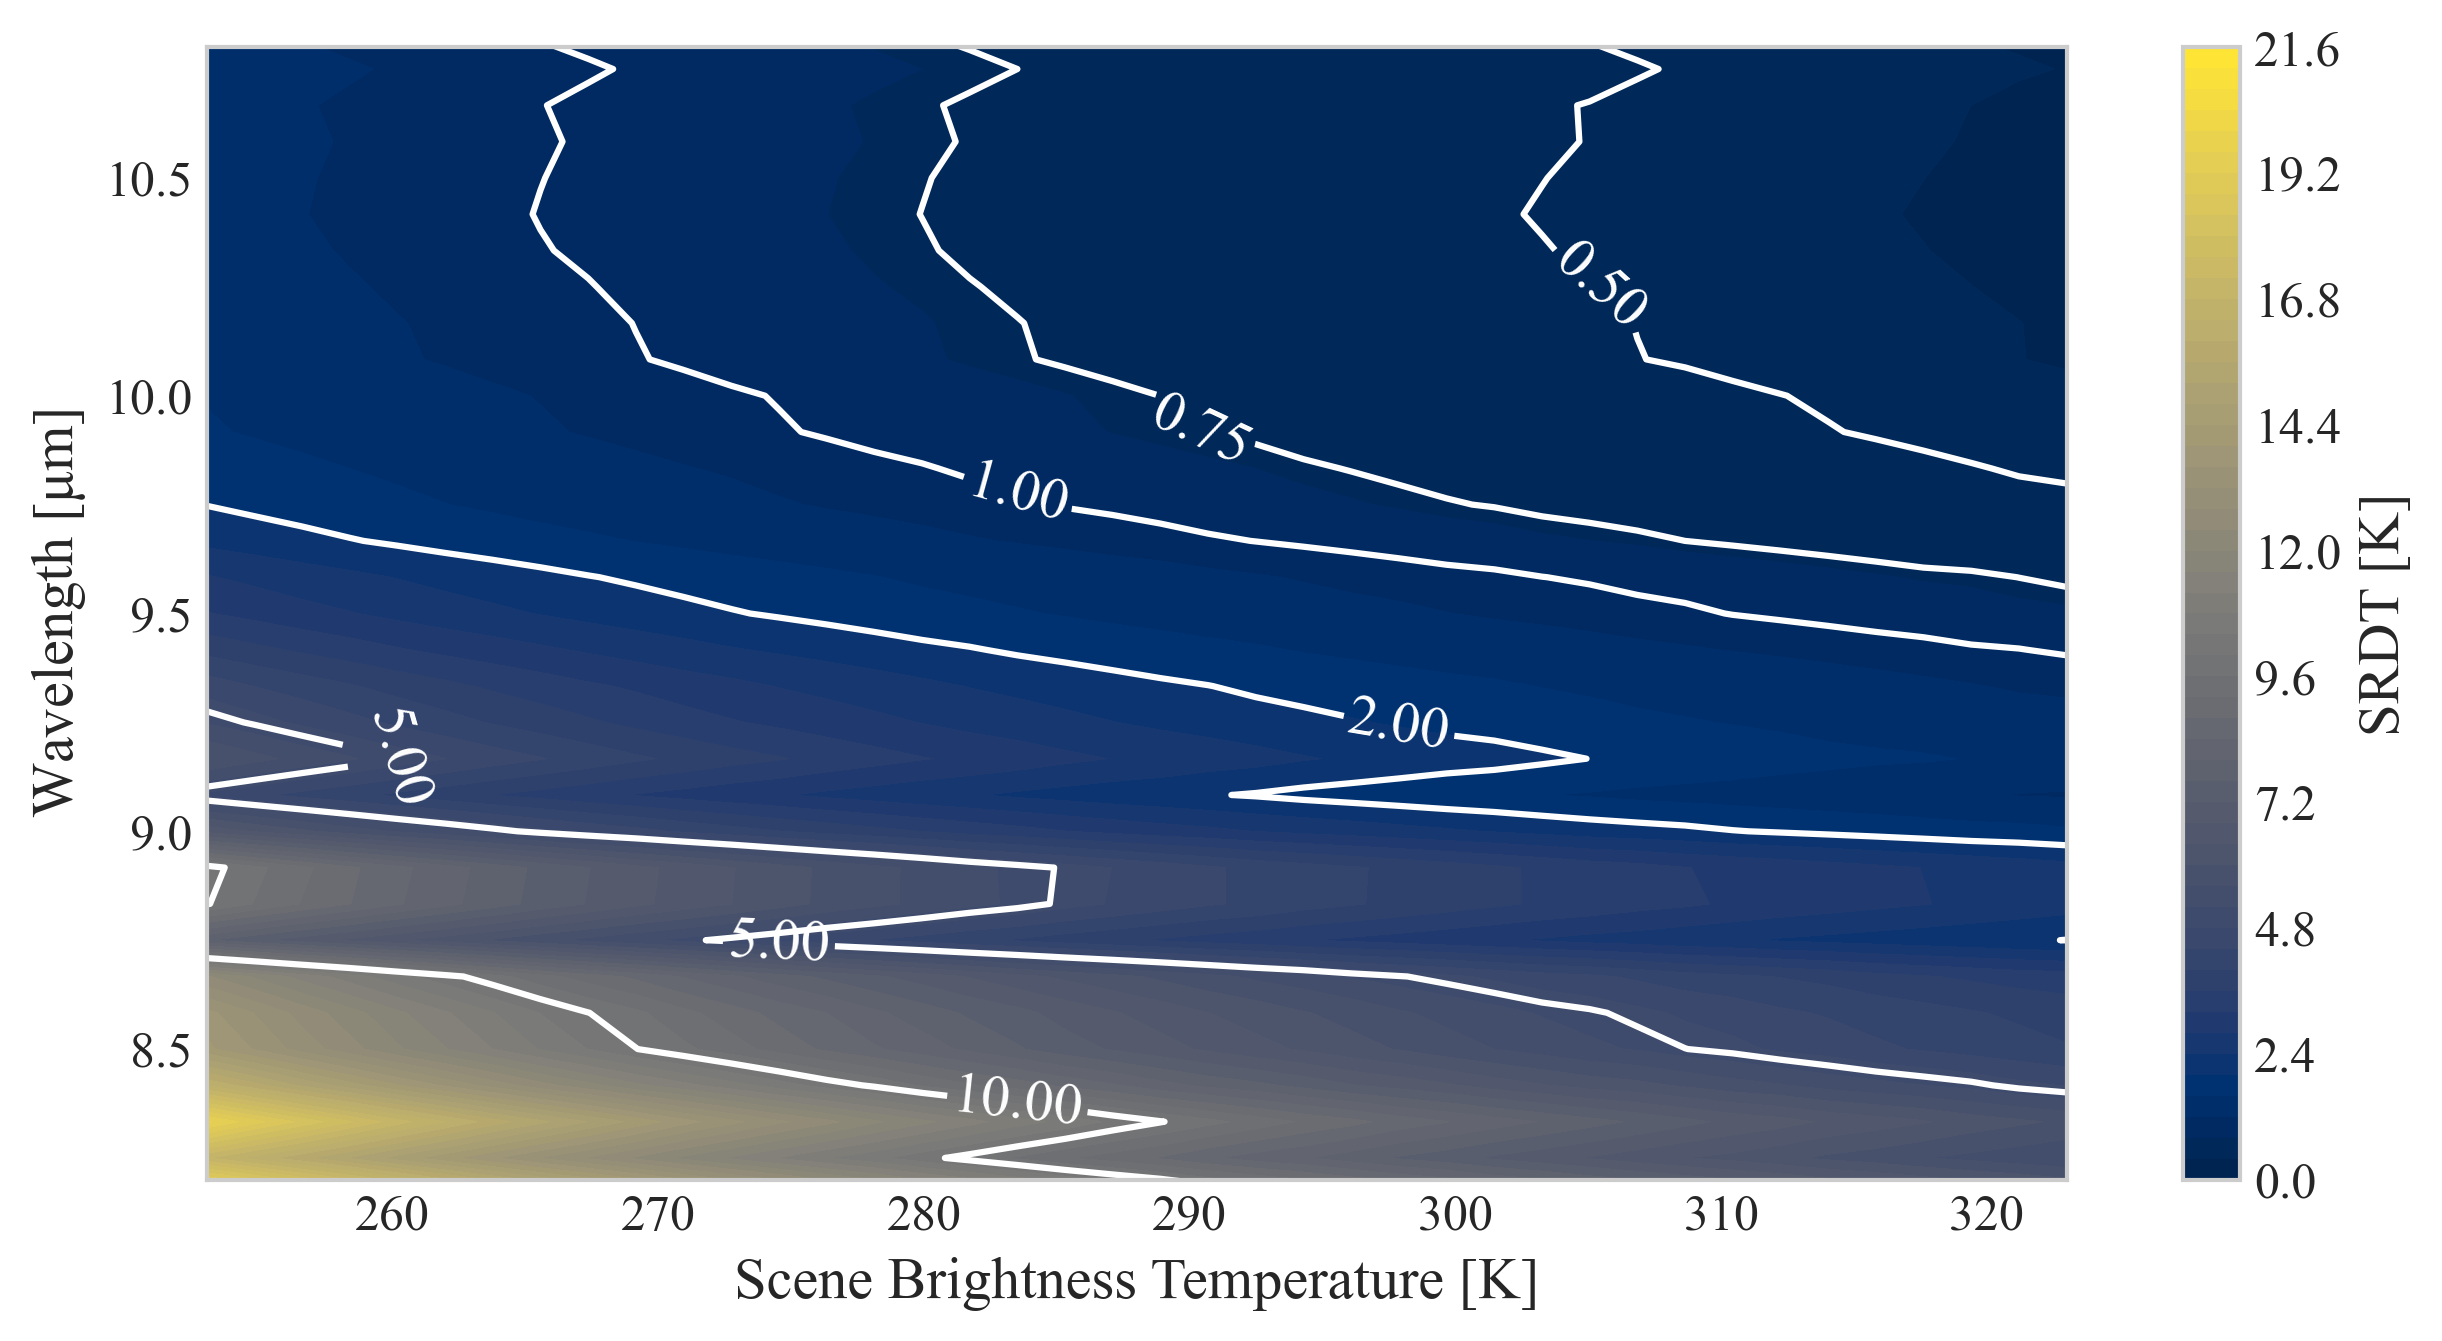

In [350]:
fig = plt.subplots(figsize = [10,5])
plt.contourf(temp,lambda_c[9:44],nedts[0:35]/np.transpose(efff),55,cmap = 'cividis',norm=cm.colors.PowerNorm(gamma=1))
plt.colorbar(label = 'SRDT [K]')
plt.ylabel("Wavelength [$\mathdefault{\mu}$m]")
plt.xlabel("Scene Brightness Temperature [K]")
levels = [0.5,0.75,1,2,5,10]
plt.gcf().set_dpi(300)
contours = plt.contour(temp,lambda_c[9:44],nedts[0:35]/np.transpose(efff), levels, colors='white')
plt.clabel(contours, inline=True, fontsize= 14)
plt.ylim(8.2,10.8)
plt.show()

azimuths = np.arange(0, 361, 1)
zeniths = np.arange(40, 70, 1)
values = azimuths * np.ones((30, 361))
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap=cmocean.cm.phase)
ax.set_yticks([])
plt.show()

(-1.0, 1.0)

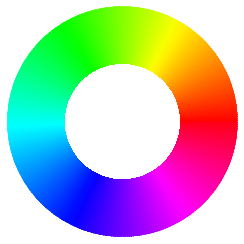

In [366]:
from matplotlib import cm
import matplotlib as mpl

fig = plt.figure()


display_axes = fig.add_axes([0.1,0.1,0.8,0.8], projection='polar')
display_axes._direction = 2*np.pi ## This is a nasty hack - using the hidden field to 
                                  ## multiply the values such that 1 become 2*pi
                                  ## this field is supposed to take values 1 or -1 only!!

norm = mpl.colors.Normalize(0.0, 2*np.pi)

# Plot the colorbar onto the polar axis
# note - use orientation horizontal so that the gradient goes around
# the wheel rather than centre out
quant_steps = 2056
cb = mpl.colorbar.ColorbarBase(display_axes, cmap=cm.get_cmap('hsv',quant_steps),
                                   norm= norm,
                                   orientation='horizontal')

# aesthetics - get rid of border and axis labels                                   
cb.outline.set_visible(False)                                 
display_axes.set_axis_off()
display_axes.set_rlim([-1,1])

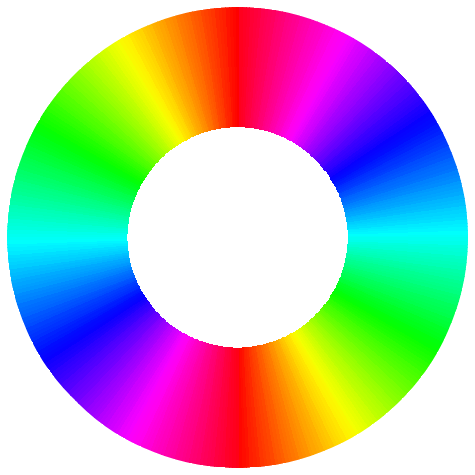

In [398]:
# Generate a figure with a polar projection
fg = plt.figure(figsize=(8,8))
ax = fg.add_axes([0.1,0.1,0.8,0.8], projection='polar')

# Define colormap normalization for 0 to 2*pi
norm = mpl.colors.Normalize(0, 2*np.pi) 

# Plot a color mesh on the pcolar plot
# with the color set by the angle

n = 200  #the number of secants for the mesh
t = np.linspace(-np.pi/2,np.pi/2,n)   #theta values
c = np.linspace(0,2*np.pi,n)
r = np.linspace(.7,1,2)        #radius values change 0.6 to 0 for full circle
rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
crg,cg  = np.meshgrid(r,c)                       #define color values as theta value
im = ax.pcolormesh(t, r, cg.T,norm=norm,cmap = 'hsv',shading = 'auto')  #plot the colormesh on axis with colormap

t = np.linspace(np.pi/2,3*np.pi/2,n)   #theta values
c = np.linspace(0,2*np.pi,n)
r = np.linspace(.7,1,2)        #radius values change 0.6 to 0 for full circle
rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
crg,cg  = np.meshgrid(r,c)                       #define color values as theta value
im = ax.pcolormesh(t, r, cg.T,norm=norm,cmap = 'hsv',shading = 'auto')
ax.set_yticklabels([]) 
ax.set_xticklabels([])  #turn of radial tick labels (yticks)
#ax.tick_params(pad=15,labelsize=24)      #cosmetic changes to tick labels
ax.spines['polar'].set_visible(False)    #turn off the axis spine.

Text(0.5, 0, 'Modulation Function \n')

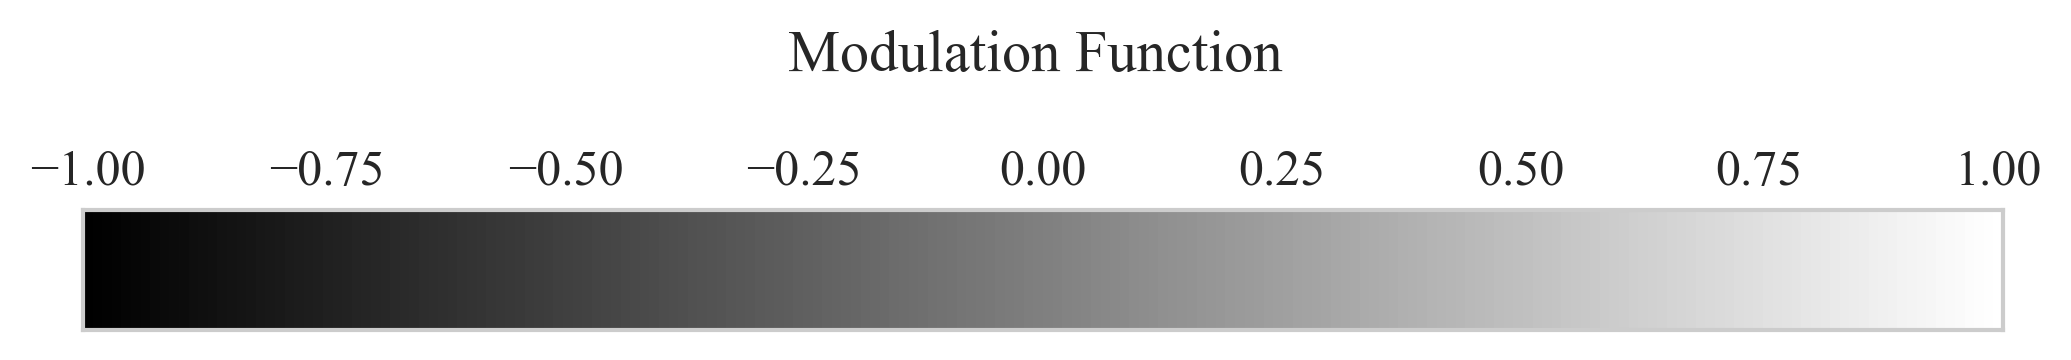

In [429]:
# Generate a figure with a polar projection
fg = plt.figure(figsize=(8,0.5))
ax = fg.add_axes([0.1,0.1,0.8,0.8])

# Define colormap normalization for 0 to 2*pi
norm = mpl.colors.Normalize(-1, 1) 

# Plot a color mesh on the polar plot
# with the color set by the angle

n = 200  #the number of secants for the mesh
x = [0,1,2]   #theta values
y = np.linspace(-1,1,n)       #radius values change 0.6 to 0 for full circle
X,Y= np.meshgrid(x,y)      #create a r,theta meshgrid                      #define color values as theta value
im = ax.pcolormesh( Y,X,Y,norm=norm,cmap = 'gray',shading = 'auto')  #plot the colormesh on axis with colormap
plt.yticks([])
plt.gcf().set_dpi(300)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel('Modulation Function \n') 
